**Analisi sulle Serie Temporali - Dataset Rain in Australia (https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)**

- L'obiettivo del progetto è stato quello di effettuare l'analisi temporale su dati metereologici forniti dal dataset pubblico Rain in Australia.

- In particolare, oltre ad una fase preliminare di esplorazione ed analisi del dataset, sono stati costruiti 2 modelli: VAR e Logistic Regression.

- Il primo di questi è stato usato per effettuare un forecasting sulle variabili numeriche più promettenti (dati sulla temperatura e sulla pressione).

- Il secondo invece è stato usato per cercare di prevedere il valore della variabile categorica RainTomorrow, utile per capire se, appunto, il giorno successivo ci sarà pioggia o meno.
Allo stato dell'arte il regressore logistico ha una precisione dell'85%.

In [ ]:
#Da eseguire una volta sola
#!pip3 install seaborn
#!pip3 install statsmodels
#!pip3 install sklearn
#!pip install statsmodels --upgrade

**Import**

In [ ]:
import warnings

In [ ]:
#Ignoriamo i vari warning delle import
warnings.filterwarnings("ignore")

In [ ]:
# Cella per tutte le import necessarie
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import difflib
from sklearn.impute import KNNImputer
from google.colab import drive

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from pandas.plotting import lag_plot
from matplotlib import pyplot

from pandas import concat
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
from math import sqrt

**Google Drive mount**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importazione e lettura del dataset**

In [ ]:
# Imposto il path del dataset
DATASET_PATH = "drive/MyDrive/RainInAustralia/weatherAUS.csv"

In [ ]:
# Salvo il contenuto del dataset in un Dataframe
df = pd.read_csv(DATASET_PATH)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**Caratteristiche del dataset**

In [ ]:
# Righe e colonne del Dataframe
df.shape

(145460, 23)

In [ ]:
#Informazioni sul Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
# Informazioni sul contenuto del Dataframe
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [ ]:
# Calcolo quale è la percentuale di valori nulli nelle colonne del Dataframe
df.isnull().mean()*100

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

**Heatmap per la correlazione delle 4 variabili con RainTomorrow**

<AxesSubplot:>

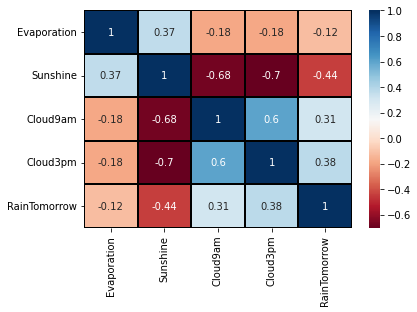

In [ ]:
# Ci sono 4 colonne che hanno un'alta percentuale di valori nulli (38-48%)
# Tali colonne sono: Evaporation (43%), Sunshine (48%), Cloud9am (38%), Cloud3pm (40%)

# Tolgo un warning di default di pandas per poter sovrascrivere le colonne del Dataframe
pd.options.mode.chained_assignment = None  # default='warn'

null_columns = df[['Evaporation', 'Sunshine', 'Cloud9am','Cloud3pm','RainTomorrow']]

# Metto la sentenza 'No' su tutta la colonna di RainTomorrow
null_columns['RainTomorrow'] = null_columns['RainTomorrow'].fillna('No')

# Faccio lo scaling nella colonna di RainTomorrow (Saranno tutti 0)
le = LabelEncoder()
null_columns['RainTomorrow'] = le.fit_transform(null_columns['RainTomorrow'])

# Uso la funzione corr() per calcolare l'indice di correlazione fra le variabili
# Con questo heatmap posso visualizzare quanto sono correlate le 4 colonne con la nostra variabile target RainTomorrow
sns.heatmap(null_columns.corr(), cmap = 'RdBu', annot = True, linewidths=1, linecolor='black')

# Possiamo vedere che Cloud9am e Cloud3pm sono correlate positivamente con RainTomorrow.
# Con Evaporation la correlazione è molto bassa.
# Con Sunshine c'è una correlazione negativa.

**Variabili numeriche**

In [ ]:
# Variabili numeriche

numeriche = [var for var in df.columns if df[var].dtype!='O']

print('Ci sono {} variabili numeriche\n'.format(len(numeriche)))

print('Le variabili numeriche sono :', numeriche)

df_num = df[numeriche]

Ci sono 16 variabili numeriche

Le variabili numeriche sono : ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


**Variabili categoriche**

In [ ]:
# Variabili categoriche

categoriche = [var for var in df.columns if df[var].dtype=='O']

print('Ci sono {} variabili categoriche\n'.format(len(categoriche)))

print('Le variabili categoriche sono :', categoriche)
df_cat = df[categoriche]

Ci sono 7 variabili categoriche

Le variabili categoriche sono : ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


**Imputing dei valori mancanti** (opzionale)

In [ ]:
# Dal momento che Evaportaion e Sunshine soffrono di mancanza dati e comunque
# non sono molto correlate con la nostra varibile target, droppo queste colonne.
# N.B. Questa istruzione va eseguita una volta sola.
df = df.drop(['Evaporation','Sunshine'], axis = 1)



imputer = KNNImputer(n_neighbors=2)

df2 = df[['MinTemp', 'MaxTemp','Rainfall','WindGustSpeed',
        'WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm',
        'Cloud9am','Cloud3pm','Temp9am','Temp3pm']]

df2 = imputer.fit_transform(df2)

**Esportazione del dataset appena imputato**

In [ ]:
df2 = pd.DataFrame(df2, columns = ['MinTemp', 'MaxTemp','Rainfall','WindGustSpeed',
 'WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm',
 'Cloud9am','Cloud3pm','Temp9am','Temp3pm'])

df2.to_csv('weatherAUS_clean.csv')

**Drop delle righe con valori nulli (se non è stato fatto l'imputing)**

In [ ]:
# Droppo tutti i campi null
df.dropna(inplace = True)

**Split della variabilie Date in colonne temporali**

In [ ]:
# Converto la colonna Date, che al momento è di tipo <object> in un formato di tipo <datetime>
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
145459   2017-06-25
Name: Date, Length: 145460, dtype: datetime64[ns]

In [ ]:
# Ora dalla colonna Date ricavo gli anni, i trimestri (quarter), mesi, settimane, giorni
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Weakday'] = df['Date'].dt.weekday
df['Day'] = df['Date'].dt.day

df[['Year','Quarter','Month','Weakday','Day']].head()

,Year,Quarter,Month,Weakday,Day
0,2008,4,12,0,1
1,2008,4,12,1,2
2,2008,4,12,2,3
3,2008,4,12,3,4
4,2008,4,12,4,5


In [ ]:
# Uso la colonna Date come indice del Dataframe
df = df.set_index('Date')

**Esplorazione del dataset**

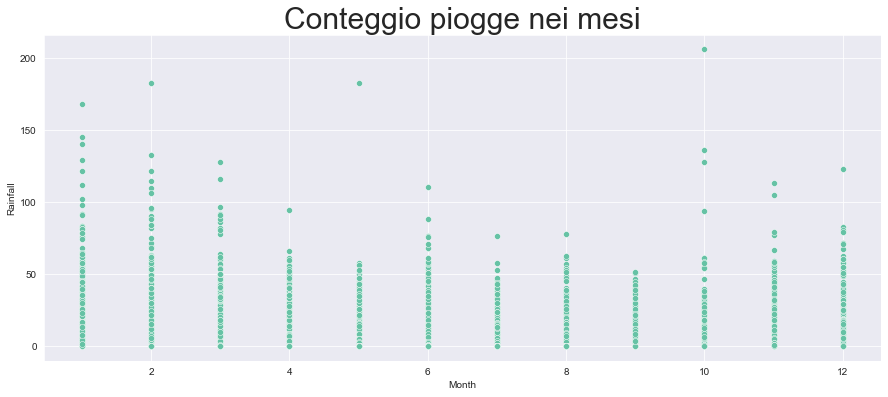

"\nPossiamo vedere che le piogge sono più dense nei mesi centrali, ovvero giugno, luglio e agosto (sono i mesi invernali in Australia).\nIn termini di intensità la pioggia è però più intensa nei mesi di Gennaio e Febbraio.\nSembra che comunque, a differenza di altri paesi, in Australia la pioggia è molto frequente in tutto l'anno\n"

In [ ]:
# Vediamo in quali mesi le piogge ci sono più spesso
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.figure(figsize=[15,6])
ax = sns.scatterplot(x = 'Month', y = 'Rainfall',data = df)
ax.set_title( "Conteggio piogge nei mesi",size = 30 )
plt.show()

'''
Possiamo vedere che le piogge sono più dense nei mesi centrali, ovvero giugno, luglio e agosto (sono i mesi invernali in Australia).
In termini di intensità la pioggia è però più intensa nei mesi di Gennaio e Febbraio.
Sembra che comunque, a differenza di altri paesi, in Australia la pioggia è molto frequente in tutto l'anno
'''

In [ ]:
# Analisi della temperatura

# Creo una nuova colonna che calcola la differenza di temperatura fra le varie ore della giornata
df['Temp_diff'] = df['Temp3pm'] - df['Temp9am']

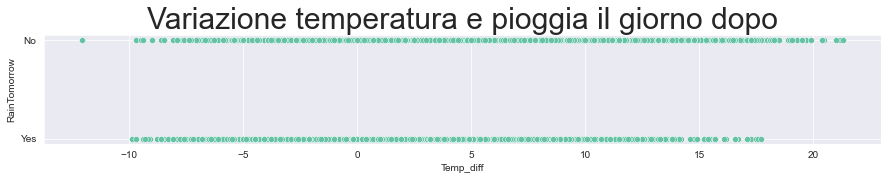

'\nSembra che solo con una variazione di temperatura notevole (maggiore di 18 gradi) possiamo dire\ncon certezza che il giorno dopo non pioverà.\nTuttavia, pare che la sola variazione di temperatura non è sufficiente per stabilire\ncon un buon grado di fiducia se il giorno dopo pioverà o meno.\n'

In [ ]:
# Vedo se una variazione della temperatura provoca pioggia il giorno dopo
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.figure(figsize=[15,2])
ax = sns.scatterplot(x = 'Temp_diff', y = 'RainTomorrow',data = df)
ax.set_title( "Variazione temperatura e pioggia il giorno dopo",size = 30 )
plt.show()

'''
Sembra che solo con una variazione di temperatura notevole (maggiore di 18 gradi) possiamo dire
con certezza che il giorno dopo non pioverà.
Tuttavia, pare che la sola variazione di temperatura non è sufficiente per stabilire
con un buon grado di fiducia se il giorno dopo pioverà o meno.
'''

In [ ]:
# Creo una nuova colonna che calcola la differenza di pressione nelle varie ore della giornata
df['WindPressure_diff'] = df['Pressure3pm'] - df['Pressure9am']


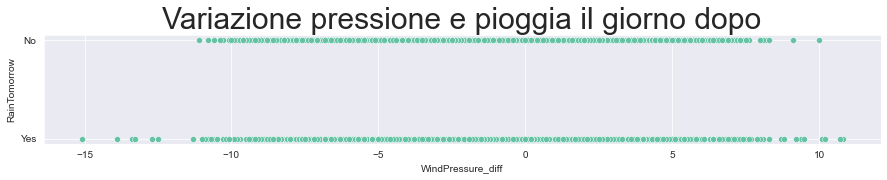

"\nLo stesso discorso vale per la pressione. Non è un indicatore sufficiente da solo ma possiamo dire che \ncon una variazione molto negativa della pressione, il giorno dopo c'è pioggia.\n\n"

In [ ]:
# Vedo se la variazione della pressione provoca pioggia il giorno dopo
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.figure(figsize=[15,2])
ax = sns.scatterplot(x = 'WindPressure_diff', y = 'RainTomorrow',data = df)
ax.set_title( "Variazione pressione e pioggia il giorno dopo",size = 30 )
plt.show()

'''
Lo stesso discorso vale per la pressione. Non è un indicatore sufficiente da solo ma possiamo dire che 
con una variazione molto negativa della pressione, il giorno dopo c'è pioggia.

'''

In [ ]:
# Creo una nuova colonna che calcola la differenza di nuvole nelle varie ore della giornata
df['Cloud_diff'] = df['Cloud3pm'] - df['Cloud9am']

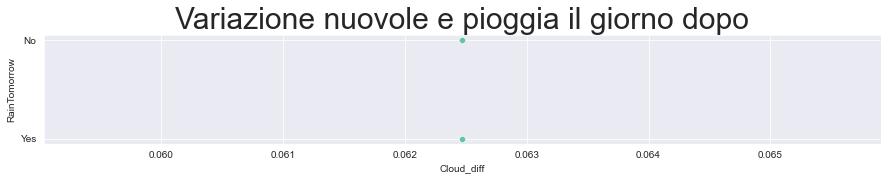

In [ ]:
#Vedo se la variazione delle nuvole provoca pioggia il giorno dopo
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.figure(figsize=[15,2])
ax = sns.scatterplot(x = 'Cloud_diff', y = 'RainTomorrow',data = df)
ax.set_title( "Variazione nuovole e pioggia il giorno dopo",size = 30 )
plt.show()

# E' sempre nuvoloso in Australia tanto è che non ci sono differenze di novole 
# durante la giornata ?!

In [ ]:
# Creo una nuova colonna che calcola la differenza di umidità nelle varie ore della giornata
df['Humidity_diff'] = df['Humidity3pm'] - df['Humidity9am']


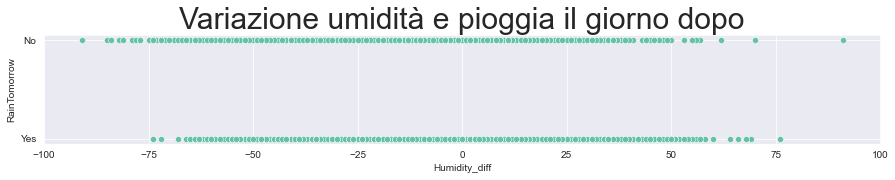

In [ ]:
#Vedo se la variazione dell'umidità provoca pioggia il giorno dopo
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.figure(figsize=[15,2])
ax = sns.scatterplot(x = 'Humidity_diff', y = 'RainTomorrow',data = df)
ax.set_title( "Variazione umidità e pioggia il giorno dopo",size = 30 )
plt.show()

# Anche qui sembra che tale metrica non sia molto utile

**Serie temporale sulla variabile categorica RainTomorrow**

In [ ]:
# A questo punto il modo migliore è quello di creare un modello di regressione (Logistic Regression)

Optimization terminated successfully.
         Current function value: inf
         Iterations 18


**Importazione del dataset imputato** (opzionale, dipende se si vuole usare questo o quello originale senza i valori mancanti)

In [ ]:
CLEANED_DATASET = "drive/MyDrive/RainInAustralia/weatherAUS_clean.csv"

In [ ]:
df_cleaned = pd.read_csv(CLEANED_DATASET)

N.B: Sostituire df con df_cleaned per usare il dataset imputato

In [ ]:
#Splitto i dati del Dataframe in training set e test set
train, test = train_test_split(df, test_size=0.05)

In [ ]:
# Converto RainTomorrow in variabile dummy
df_dummy = pd.get_dummies(train, columns=['RainTomorrow'], drop_first=True)

#Normalizzo i dati del training set (opzionale)
#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(df_dummy[['MinTemp', 'MaxTemp','Rainfall','WindGustSpeed',
#        'WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm',
#        'Cloud9am','Cloud3pm','Temp9am','Temp3pm','RainTomorrow_Yes']])

Fitting del modello

In [ ]:
# Converto la variabile categorica RainToday in variabile numerica (Yes-No --> 1-0)
le = LabelEncoder()
train['RainToday'] = le.fit_transform(train['RainToday'])

# Prendo le variabili numeriche
X = train[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm','RainToday']]

# Variabile Target
Y = df_dummy['RainTomorrow_Yes']

# Fitting del modello
log_reg = sm.Logit(list(Y), X, missing="drop").fit(method='bfgs')
log_reg.summary()

         Current function value: 0.338602
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                53599
Model:                          Logit   Df Residuals:                    53582
Method:                           MLE   Df Model:                           16
Date:                Mon, 17 Jan 2022   Pseudo R-squ.:                  0.3584
Time:                        15:32:30   Log-Likelihood:                -18149.
converged:                      False   LL-Null:                       -28285.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
MinTemp          -0.0463      0.008     -6.120      0.000      -0.061      -0.031
MaxTemp           0.0404      0.012      3.318      0.001       0.017       0.064
Rainfall          0.0131      0.002      6.050      0.000       0.009       0.017
Evaporation      -0.0021      0.006     -0.360      0.719      -0.014       0.009
Sunshine         -0.1388      0.006    -22.409      0.000      -0.151      -0.127
WindGustSpeed     0.0717      0.002     46.414      0.000       0.069       0.075
WindSpeed9am     -0.0173      0.002     -8.061      0.000      -0.021      -0.013
WindSpeed3pm     -0.0287      0.002    -12.854      0.000      -0.033      -0.024
Humidity9am       0.0037      0.002      2.276      0.023       0.001       0.007
Humidity3pm       0.0568      0.002     33.407      0.000       0.053       0.060
Pressure9am       0.1648      0.008     20.232      0.000       0.149       0.181
Pressure3pm      -0.1727      0.008    -21.191      0.000      -0.189      -0.157
Cloud9am         -0.0053      0.008     -0.698      0.485      -0.020       0.010
Cloud3pm          0.1267      0.008     15.242      0.000       0.110       0.143
Temp9am           0.0518      0.011      4.639      0.000       0.030       0.074
Temp3pm          -0.0160      0.014     -1.167      0.243      -0.043       0.011
RainToday         0.5172      0.037     14.057      0.000       0.445       0.589
=================================================================================
"""

Predizione

In [ ]:
#Predizione
Xtest = test[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm','RainToday']]
Xtest['RainToday'] = le.fit_transform(Xtest['RainToday'])       

ytest = test['RainTomorrow']

yhat = log_reg.predict(Xtest)
prediction = list(map(round, yhat))
 
# comparing original and predicted values of y

print("Il test è stato valutato su "+str(len(list(ytest.values)))+" dati metereologici (10% del dataset)")

true_values = [None] * len(list(ytest.values))

# Mappo le sentenze Yes-No in 1-0 
for i in range(len(list(ytest.values))):
    if list(ytest.values)[i] == 'Yes':
        true_values[i] = 1
    else:
        true_values[i] = 0
        
# Calcolo la percentuale di precisione delle previsioni
total = len(true_values)
true_predict = 0
for i in range(len(true_values)):
    if true_values[i] == prediction[i]:
        true_predict += 1
        
print( "La precision del modello è del "+str((true_predict*100)/len(true_values)) +"%")

Il test è stato valutato su 2821 dati metereologici (10% del dataset)
La precision del modello è del 85.14711095356256%


In [ ]:
print("Valori veri: "+str(true_values))
print("\n")
print("Valori predetti: "+str(prediction))

Valori veri: [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

**AUTOCORRELAZIONE DELLE VARIABILI NUMERICHE DEL DATASET**

Autocorrelation

Facciamo un check visuale per vedere se ci può essere **autocorrelazione** nella variabili del dataset
lag_plot() permette di visualizzare le osservazioni allo step t-1
con le osservazioni allo step successivo , t+1.
Se gli scatter formano una diagonale allora la variabile ha un buon grado di autocorrelazione.

Inoltre viene calcolato l'**indice di correlazione di Pearson** per avere una metrica oggettiva circa il valore di autocorrelazione. I valori vanno da -1 (alta correlazione negativa) a 1 (alta correlazione positiva). 

MinTemp

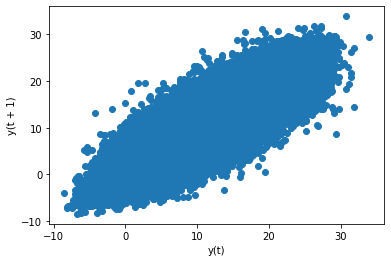



Indice di correlazione di Pearson: 
         t-1      t+1
t-1  1.00000  0.88584
t+1  0.88584  1.00000


In [ ]:
# Disegno il grafico
lag_plot(df['MinTemp'])
pyplot.show()

# Calcolo l'indice di correlazione
values = DataFrame(df['MinTemp'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

MaxTemp

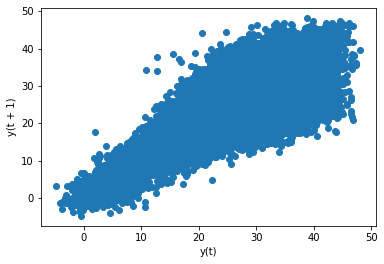



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.874573
t+1  0.874573  1.000000


In [ ]:
lag_plot(df['MaxTemp'])
pyplot.show()

values = DataFrame(df['MaxTemp'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Rainfall

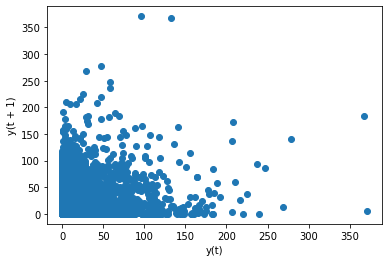



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.308536
t+1  0.308536  1.000000


In [ ]:
lag_plot(df['Rainfall'])
pyplot.show()

values = DataFrame(df['Rainfall'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Evaporation

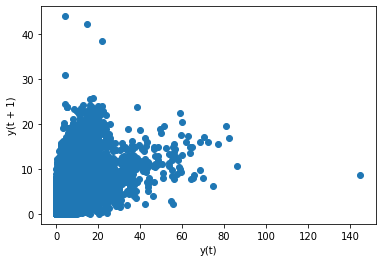



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.645482
t+1  0.645482  1.000000


In [ ]:
lag_plot(df['Evaporation'])
pyplot.show()

values = DataFrame(df['Evaporation'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Sunshine

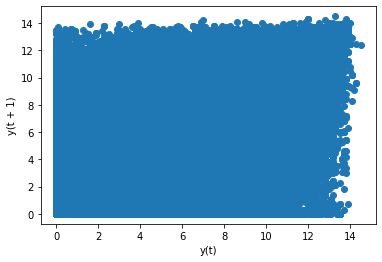



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.488973
t+1  0.488973  1.000000


In [ ]:
lag_plot(df['Sunshine'])
pyplot.show()

values = DataFrame(df['Sunshine'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Velocità del vento

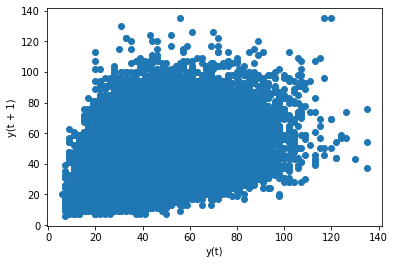



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.455652
t+1  0.455652  1.000000


In [ ]:
lag_plot(df['WindGustSpeed'])
pyplot.show()

values = DataFrame(df['WindGustSpeed'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Velocità del vento alle 9:00

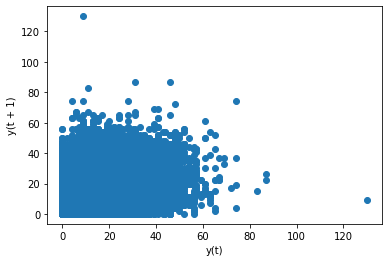



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.424187
t+1  0.424187  1.000000


In [ ]:
lag_plot(df['WindSpeed9am'])
pyplot.show()

values = DataFrame(df['WindSpeed9am'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Velocità del vento alle 15:00

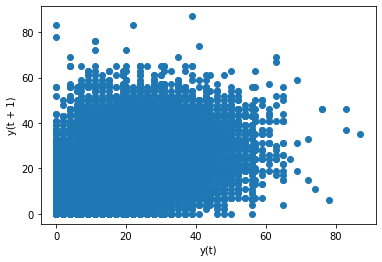



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.398061
t+1  0.398061  1.000000


In [ ]:
lag_plot(df['WindSpeed3pm'])
pyplot.show()

values = DataFrame(df['WindSpeed3pm'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Umidità alle 9:00

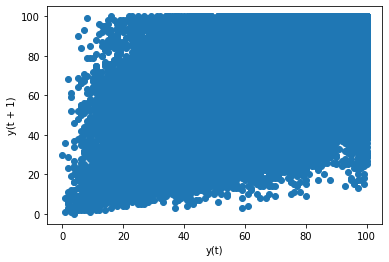



Indice di correlazione di Pearson: 
         t-1      t+1
t-1  1.00000  0.64967
t+1  0.64967  1.00000


In [ ]:
lag_plot(df['Humidity9am'])
pyplot.show()

values = DataFrame(df['Humidity9am'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Umidità alle 15:00

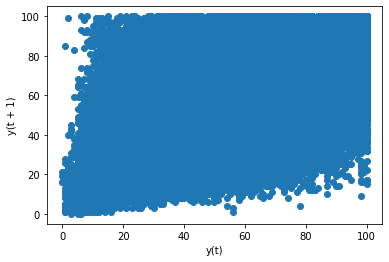



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.653239
t+1  0.653239  1.000000


In [ ]:
lag_plot(df['Humidity3pm'])
pyplot.show()

values = DataFrame(df['Humidity3pm'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Pressione alle 9:00

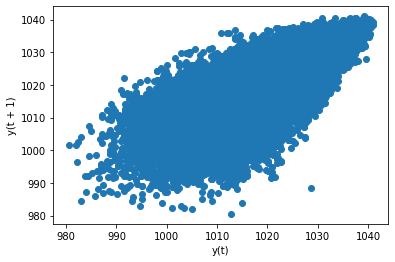



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.748717
t+1  0.748717  1.000000


In [ ]:
lag_plot(df['Pressure9am'])
pyplot.show()

values = DataFrame(df['Pressure9am'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Pressione alle 15:00

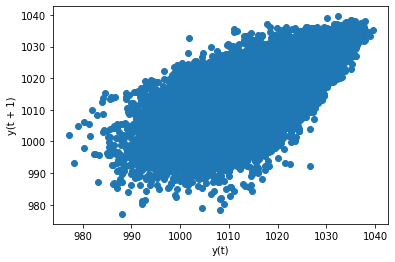



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.755469
t+1  0.755469  1.000000


In [ ]:
lag_plot(df['Pressure3pm'])
pyplot.show()

values = DataFrame(df['Pressure3pm'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Nuvole alle 9:00

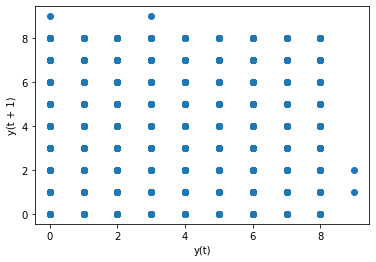



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.389219
t+1  0.389219  1.000000


In [ ]:
lag_plot(df['Cloud9am'])
pyplot.show()

values = DataFrame(df['Cloud9am'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Nuvole alle 15:00

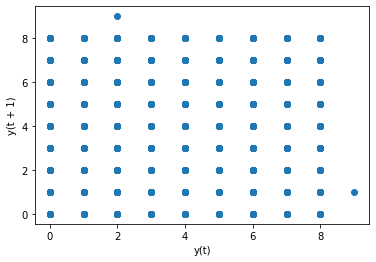



Indice di correlazione di Pearson: 
         t-1      t+1
t-1  1.00000  0.38356
t+1  0.38356  1.00000


In [ ]:
lag_plot(df['Cloud3pm'])
pyplot.show()

values = DataFrame(df['Cloud3pm'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Temperatura alle 9:00

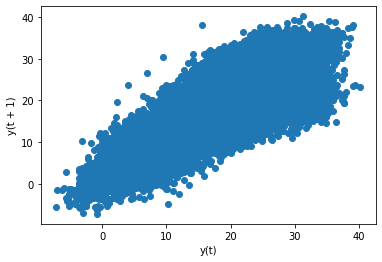



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.896026
t+1  0.896026  1.000000


In [ ]:
lag_plot(df['Temp9am'])
pyplot.show()

values = DataFrame(df['Temp9am'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Temperatura alle 15:00

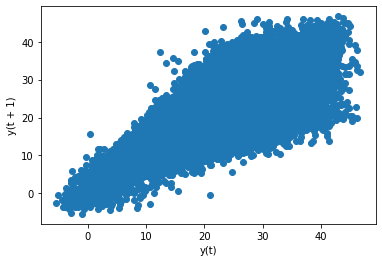



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.855971
t+1  0.855971  1.000000


In [ ]:
lag_plot(df['Temp3pm'])
pyplot.show()

values = DataFrame(df['Temp3pm'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

Sembra che non tutte le variabili numeriche del dataset abbiano una buona autocorrelazione.
A questo punto decidiamo di procedere con le serie temporali sulle variabili che presentano i migliori valori di autocorrelazione: MinTemp, MaxTemp, Pressure9am, Pressure3pm, Temp9am, Temp3pm.

**Stazionarietà delle serie**

Prima di effettuare l'analisi, andiamo a verificare se i dati delle serie temporali sono stazionari.

Per far questo andiamo adottiamo due vie:
1) plottare il grafico della serie e assicurarci che non ci siano trend
2) Divido la serie in due sottogruppi e mi assicuro che la media e la varianza di essi non discostino di troppo tra loro

MinTemp

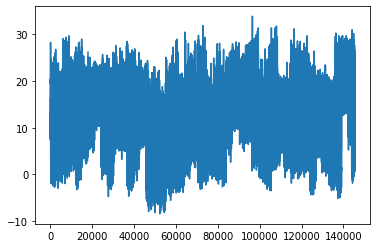

Media dei sottogruppi: +11.343673828370447 13.03601404401187
Varianza dei sottogruppi: 39.27326191254065 41.1674098255499


In [296]:
df['MinTemp'].plot()
pyplot.show()

X = df['MinTemp']
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print("Media dei sottogruppi: ",end="")
print(mean1, mean2)
print("Varianza dei sottogruppi: ",end="")
print(var1, var2)


MaxTemp

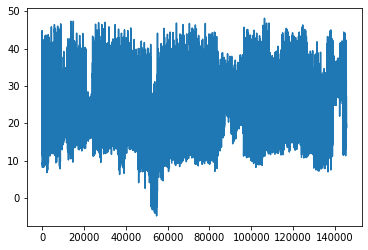

Media dei sottogruppi: 22.284644632933965 24.150276243093792
Varianza dei sottogruppi: 47.62881251159561 51.97520344859817


In [297]:
df['MaxTemp'].plot()
pyplot.show()

X = df['MaxTemp']
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print("Media dei sottogruppi: ",end="")
print(mean1, mean2)
print("Varianza dei sottogruppi: ",end="")
print(var1, var2)

Pressure9am

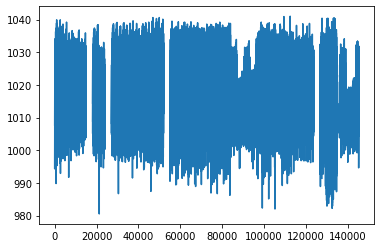

Media dei sottogruppi: 1018.25817982914 1017.0958687496333
Varianza dei sottogruppi: 50.06200615312393 50.2610124628166


In [298]:
df['Pressure9am'].plot()
pyplot.show()

X = df['Pressure9am']
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print("Media dei sottogruppi: ",end="")
print(mean1, mean2)
print("Varianza dei sottogruppi: ",end="")
print(var1, var2)

Pressure9pm

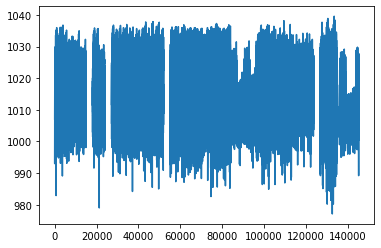

Media dei sottogruppi: 1015.8616041150964 1014.7035516402262
Varianza dei sottogruppi: 48.35911368188225 49.94959249259776


In [299]:
df['Pressure3pm'].plot()
pyplot.show()

X = df['Pressure3pm']
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print("Media dei sottogruppi: ",end="")
print(mean1, mean2)
print("Varianza dei sottogruppi: ",end="")
print(var1, var2)

Temp9am

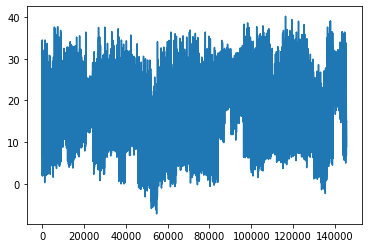

Media dei sottogruppi: 15.893405607057252 18.071381406271612
Varianza dei sottogruppi: 36.73701802637251 45.03692855073873


In [300]:
df['Temp9am'].plot()
pyplot.show()

X = df['Temp9am']
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print("Media dei sottogruppi: ",end="")
print(mean1, mean2)
print("Varianza dei sottogruppi: ",end="")
print(var1, var2)

Temp9pm

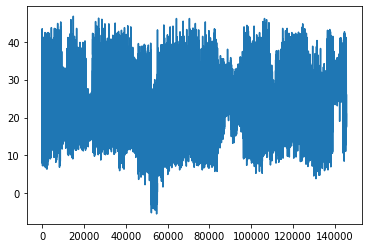

Media dei sottogruppi: 20.83885992795097 22.52458137505979
Varianza dei sottogruppi: 45.10772092557841 49.69726206706123


In [301]:
df['Temp3pm'].plot()
pyplot.show()

X = df['Temp3pm']
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print("Media dei sottogruppi: ",end="")
print(mean1, mean2)
print("Varianza dei sottogruppi: ",end="")
print(var1, var2)

Ok, le serie sono stazionarie. Procediamo con la modellazione.

**Vector Autoregression (VAR)**

In [ ]:
# Raccolgo le variabili su cui voglio effettuare l'analisi temporale
X = df[['Temp9am','Temp3pm','MinTemp','MaxTemp','Pressure9am','Pressure3pm']]
X = X.dropna()

# Splitto il dataset in train e test
# Lascio 1500 righe per il test
train, test = X[1:len(X)-1500], X[len(X)-1500:]

Model fitting

In [ ]:
model = VAR(train)
results = model.fit()
results.summary()
#results.plot()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Jan, 2022
Time:                     12:40:04
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    8.77204
Nobs:                     126746.    HQIC:                   8.76978
Log likelihood:      -1.63473e+06    FPE:                    6430.52
AIC:                      8.76881    Det(Omega_mle):         6428.39
--------------------------------------------------------------------
Results for equation Temp9am
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                -54.397816         1.240109          -43.865           0.000
L1.Temp9am             0.528440         0.004154          127.221           0.000
L1.Temp3pm             0.272771         0.006404      

Lag order selection

In [ ]:
#results.plot_acorr()
model.select_order(10)
results = model.fit(maxlags=15, ic='aic')
lag_order = results.k_ar

Forecasting

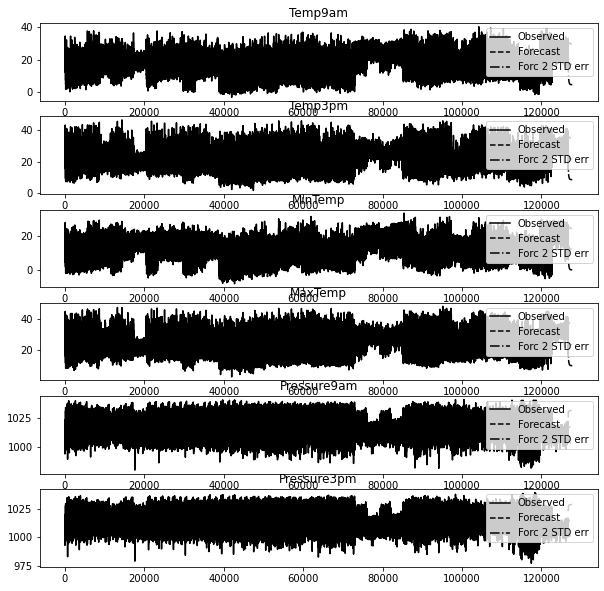

In [ ]:
results.forecast(test.values[-lag_order:], 5)
results.plot_forecast(1000);

Risposta all'impulso

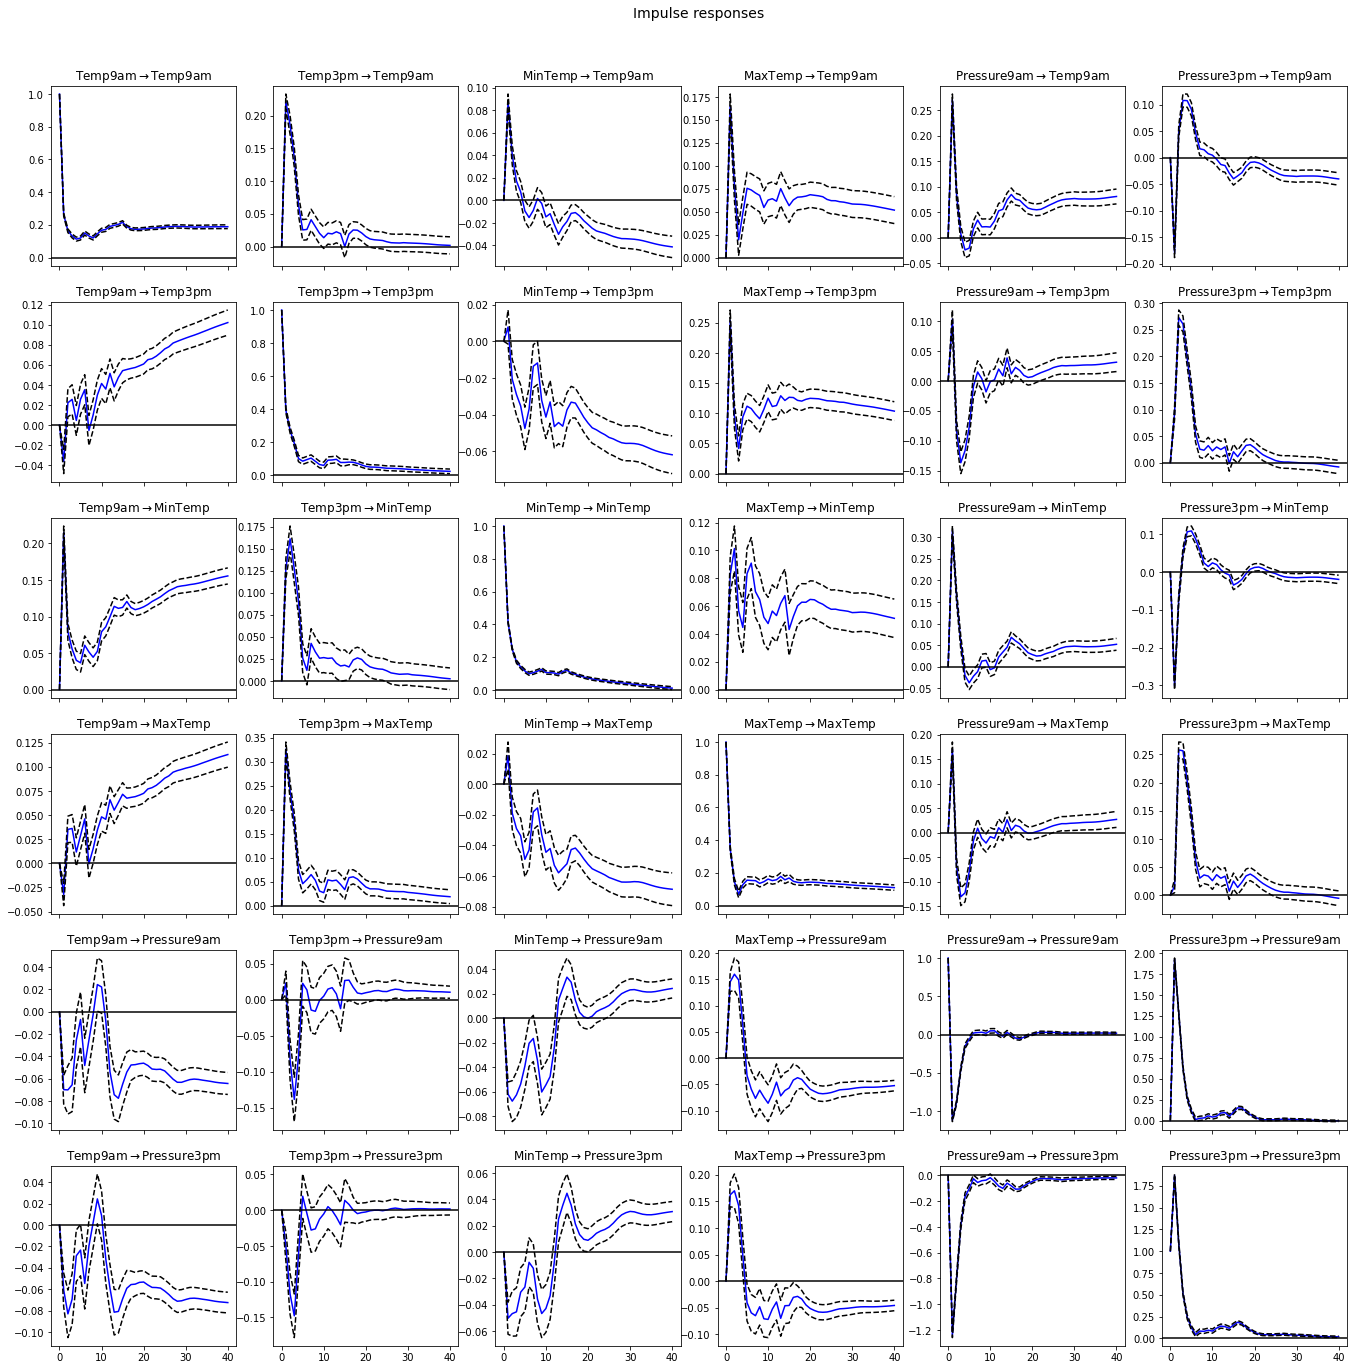

In [266]:
irf = results.irf(40)
irf.plot(orth=False, figsize=(20,20));

Forecast Error Variance Decomposition (FEVD)

In [254]:
# Il contributo di informazione che ogni variabile fornisce alle altre variabili nell'autoregressione
# Con se stessa il valore deve essere alto, con gli altri basso
fevd = results.fevd(1)
fevd.summary()

FEVD for Temp9am
      Temp9am   Temp3pm   MinTemp   MaxTemp  Pressure9am  Pressure3pm
0    1.000000  0.000000  0.000000  0.000000     0.000000     0.000000

FEVD for Temp3pm
      Temp9am   Temp3pm   MinTemp   MaxTemp  Pressure9am  Pressure3pm
0    0.292511  0.707489  0.000000  0.000000     0.000000     0.000000

FEVD for MinTemp
      Temp9am   Temp3pm   MinTemp   MaxTemp  Pressure9am  Pressure3pm
0    0.316595  0.050946  0.632459  0.000000     0.000000     0.000000

FEVD for MaxTemp
      Temp9am   Temp3pm   MinTemp   MaxTemp  Pressure9am  Pressure3pm
0    0.385090  0.497638  0.001370  0.115902     0.000000     0.000000

FEVD for Pressure9am
      Temp9am   Temp3pm   MinTemp   MaxTemp  Pressure9am  Pressure3pm
0    0.130980  0.000009  0.009950  0.027519     0.831541     0.000000

FEVD for Pressure3pm
      Temp9am   Temp3pm   MinTemp   MaxTemp  Pressure9am  Pressure3pm
0    0.111927  0.032225  0.004553  0.026839     0.709755     0.114701




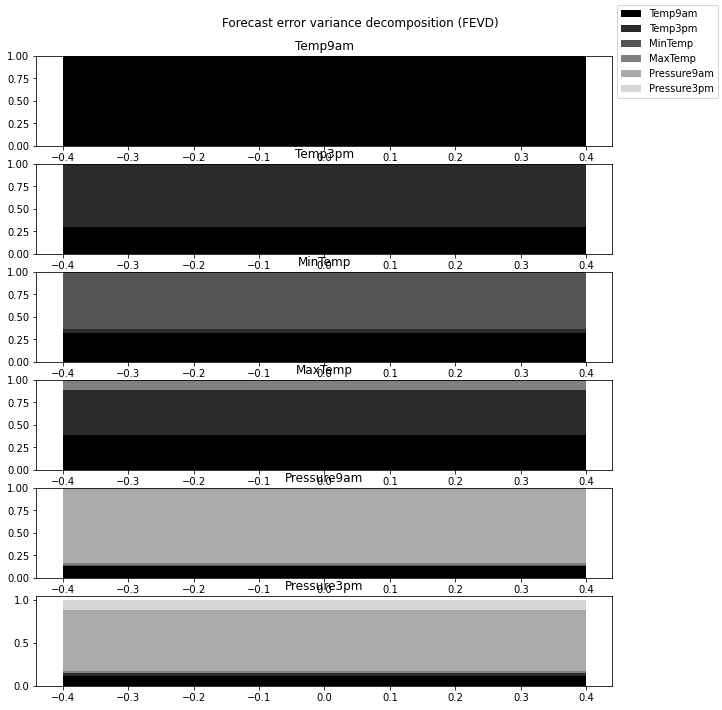

In [255]:
results.fevd(1).plot();

**AutoReg** (da migliorare o togliere proprio)

predicted=11.119402, expected=7.900000
predicted=11.169794, expected=9.500000
predicted=10.995950, expected=9.100000
predicted=10.819150, expected=8.700000
predicted=10.710497, expected=8.200000
predicted=10.576754, expected=8.000000
predicted=10.448503, expected=8.500000
predicted=10.584833, expected=10.300000
predicted=10.764421, expected=8.900000
predicted=10.937812, expected=8.800000
predicted=11.080642, expected=12.300000
predicted=11.148474, expected=11.200000
predicted=11.171046, expected=11.600000
predicted=11.189814, expected=11.000000
predicted=11.217004, expected=9.400000
predicted=11.249151, expected=10.100000
predicted=11.289533, expected=10.900000
predicted=11.348830, expected=12.500000
predicted=11.416358, expected=15.100000
predicted=11.484157, expected=15.000000
Test RMSE: 1.998


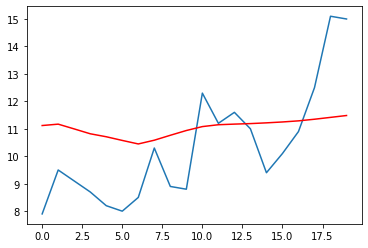

In [ ]:
model = AutoReg(train, lags=10,missing="drop")
model_fit = model.fit()
#print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
 
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()